<a href="https://colab.research.google.com/github/ziharadelgado/sam2-vidio-annotation/blob/main/Semi_Automatic_Annotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We annotate one frame, and it tracks the object through the entire video --> SAM 2

In [ ]:
# Check GPU
!nvidia-smi

Tue Feb  3 17:22:21 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Install SAM-2

In [ ]:
!pip install -q git+https://github.com/facebookresearch/sam2.git
!pip install -q opencv-python matplotlib supervision

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 kB 9.1 MB/s eta 0:00:00


Download checkpoint

In [ ]:
!mkdir -p checkpoints
!wget -q -P checkpoints https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt
print('✓ SAM 2 checkpoint downloaded!')

✓ SAM 2 checkpoint downloaded!


Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Configure paths

Find the exact path to the vidio in my drive

In [ ]:
# Search the video file
!find /content/drive/MyDrive -name "*Apristurus*" -type f 2>/dev/null

/content/drive/MyDrive/inaturalist_sharks_download/images/Apristurus_brunneus_14997280_22373545.jpg
/content/drive/MyDrive/inaturalist_sharks_download/images/Apristurus_brunneus_11139680_15757862.jpg
/content/drive/MyDrive/inaturalist_sharks_download/images/Apristurus_brunneus_11139680_15757867.jpg
/content/drive/MyDrive/inaturalist_sharks_download/images/Apristurus_10836790_15189876.jpg
/content/drive/MyDrive/Apristurus_NOAA_EX1606_VID_20160811T025438Z_ROVHD_SHARK.mov
/content/drive/MyDrive/Apristurus_NOAA_EX1304L2_VID_20130816T154851Z_ROVHD_CAT_SHARK.mov


Convert MOV to MP4

In [ ]:
# Convert MOV to MP4
INPUT_VIDEO = '/content/drive/MyDrive/Apristurus_NOAA_EX1304L2_VID_20130816T154851Z_ROVHD_CAT_SHARK.mov'
OUTPUT_VIDEO = '/content/shark_video.mp4'

!ffmpeg -i "{INPUT_VIDEO}" -c:v libx264 -preset fast -crf 22 "{OUTPUT_VIDEO}" -y

print('✓ Conversion complete!')

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
# === CONFIGURE THE VIDEO PATH ===
VIDEO_PATH = '/content/shark_video.mp4'

# Output settings
OUTPUT_DIR = '/content/annotated_frames'
FRAME_RATE = 5  # Extract N frames per second

check if it works

Video opened: True
Total frames: 3115
FPS: 29.97
✓ Frame read successfully!


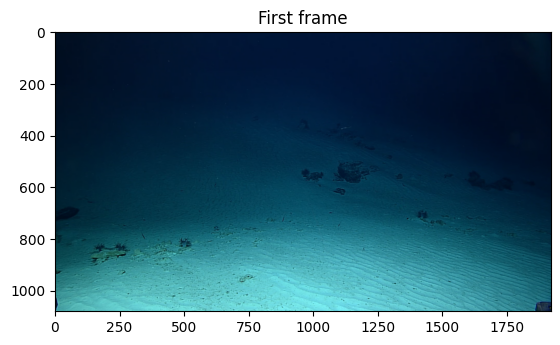

In [ ]:
import cv2

cap = cv2.VideoCapture(VIDEO_PATH)
print(f"Video opened: {cap.isOpened()}")
print(f"Total frames: {int(cap.get(cv2.CAP_PROP_FRAME_COUNT))}")
print(f"FPS: {cap.get(cv2.CAP_PROP_FPS)}")

# Read and show a frame
ret, frame = cap.read()
if ret:
    print("✓ Frame read successfully!")
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title('First frame')
    plt.show()
else:
    print("✗ Could not read frame")

cap.release()

In [ ]:
frames_dir, num_frames = extract_frames(VIDEO_PATH, OUTPUT_DIR, FRAME_RATE)

✓ Extracted 623 frames at 5 FPS


Extract frames from video

In [ ]:
import cv2
import os
import numpy as np
from pathlib import Path

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(f'{OUTPUT_DIR}/images', exist_ok=True)
os.makedirs(f'{OUTPUT_DIR}/labels', exist_ok=True)

def extract_frames(video_path, output_dir, fps=5):
    cap = cv2.VideoCapture(video_path)
    video_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(video_fps / fps)

    frames_dir = f'{output_dir}/video_frames'
    os.makedirs(frames_dir, exist_ok=True)

    frame_count = 0
    saved_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_interval == 0:
            frame_path = f'{frames_dir}/{saved_count:05d}.jpg'
            cv2.imwrite(frame_path, frame)
            saved_count += 1

        frame_count += 1

    cap.release()
    print(f'✓ Extracted {saved_count} frames at {fps} FPS')
    return frames_dir, saved_count

frames_dir, num_frames = extract_frames(VIDEO_PATH, OUTPUT_DIR, FRAME_RATE)

✓ Extracted 623 frames at 5 FPS


Load SAM 2

In [ ]:
import torch
from sam2.build_sam import build_sam2_video_predictor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

sam2_checkpoint = 'checkpoints/sam2_hiera_large.pt'
model_cfg = 'sam2_hiera_l.yaml'

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)
print('✓ SAM 2 loaded!')

Using device: cuda
✓ SAM 2 loaded!


View first frame

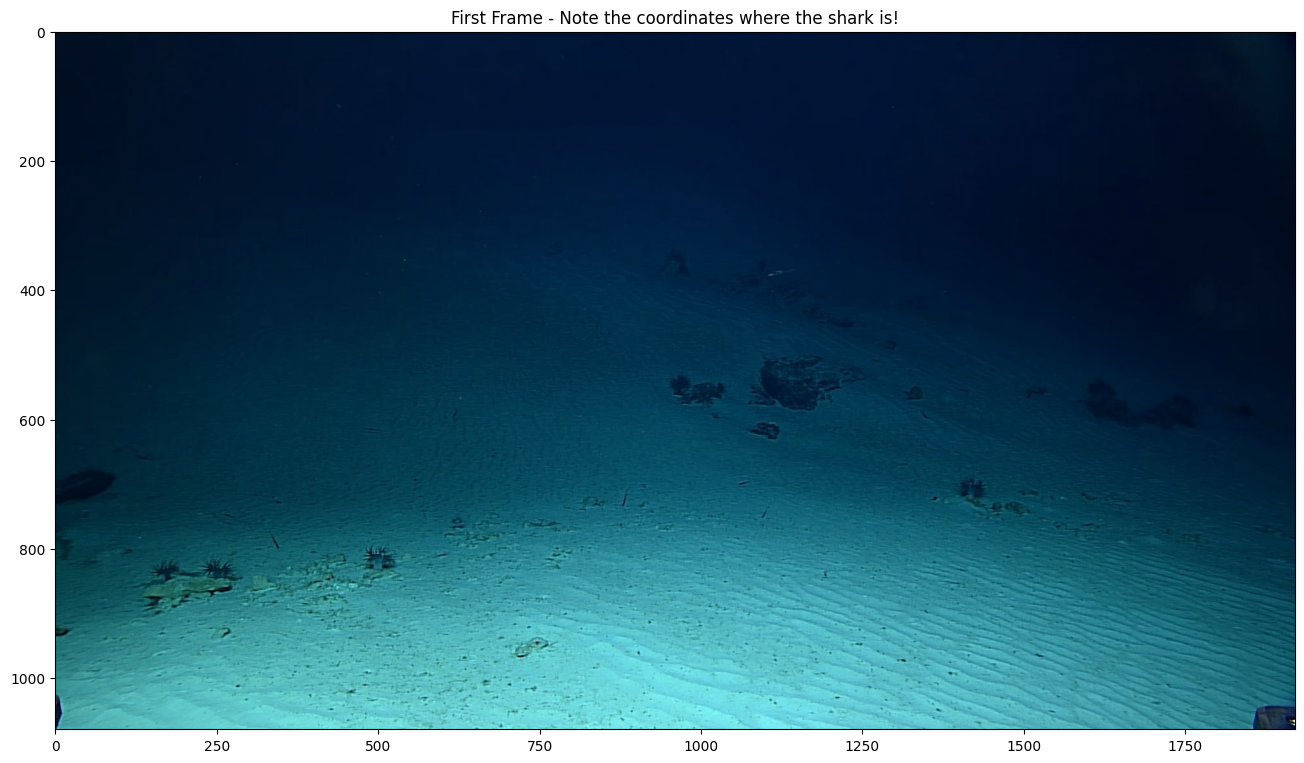

Image size: (1920, 1080)


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

first_frame_path = f'{frames_dir}/00000.jpg'
first_frame = Image.open(first_frame_path)

plt.figure(figsize=(16, 10))
plt.imshow(first_frame)
plt.title('First Frame - Note the coordinates where the shark is!')
plt.axis('on')
plt.show()

print(f'Image size: {first_frame.size}')

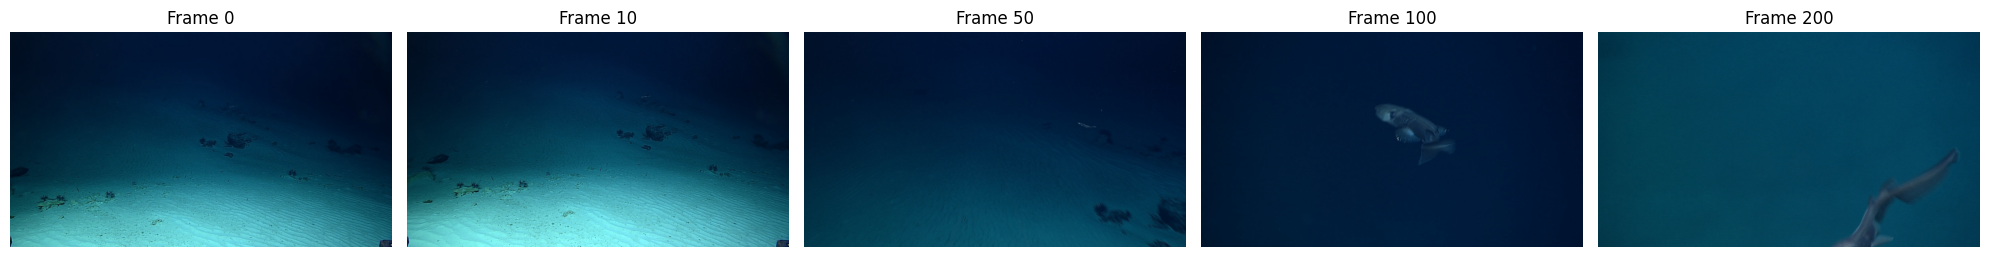

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Check frames at different points
frames_to_check = [0, 10, 50, 100, 200]

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for ax, frame_num in zip(axes, frames_to_check):
    frame_path = f'{frames_dir}/{frame_num:05d}.jpg'
    if os.path.exists(frame_path):
        img = Image.open(frame_path)
        ax.imshow(img)
        ax.set_title(f'Frame {frame_num}')
    else:
        ax.set_title(f'Frame {frame_num}\nNOT FOUND')
    ax.axis('off')

plt.tight_layout()
plt.show()

We will extract the frist frame so i can put it in rovoflow to annotate

In [ ]:
import cv2

VIDEO_PATH = '/content/shark_video.mp4'  # The converted video

cap = cv2.VideoCapture(VIDEO_PATH)
ret, frame = cap.read()
cap.release()

if ret:
    cv2.imwrite('/content/first_frame.jpg', frame)
    print('✓ Saved first_frame.jpg')

    # Download it
    from google.colab import files
    files.download('/content/first_frame.jpg')
else:
    print('Error reading video')

✓ Saved first_frame.jpg


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

I have annotate it in Rovoflow

In [ ]:
from google.colab import files

uploaded = files.upload()
zip_name = list(uploaded.keys())[0]
print(f'✓ Uploaded: {zip_name}')

Saving Apristurus-Uploaded on 02-03-26 at 11-18 am.coco.zip to Apristurus-Uploaded on 02-03-26 at 11-18 am.coco.zip
✓ Uploaded: Apristurus-Uploaded on 02-03-26 at 11-18 am.coco.zip


In [ ]:
import zipfile

with zipfile.ZipFile(zip_name, 'r') as z:
    z.extractall('/content/roboflow_export')

print('✓ Extracted! Contents:')
!find /content/roboflow_export -type f

✓ Extracted! Contents:
/content/roboflow_export/README.roboflow.txt
/content/roboflow_export/train/_annotations.coco.json
/content/roboflow_export/train/first_frame_jpg.rf.pvctxWFXp207cOxOWtvM.jpg
/content/roboflow_export/README.dataset.txt


Load annotation into colab from rovoflow

In [ ]:
import json

# Load the annotation file
with open('/content/roboflow_export/train/_annotations.coco.json', 'r') as f:
    coco = json.load(f)

# Get the shark polygon
polygon = coco['annotations'][0]['segmentation'][0]
print(f'✓ Found polygon with {len(polygon)//2} points!')

✓ Found polygon with 14 points!


Create mask

In [ ]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Load first frame from YOUR video (not Roboflow's copy)
first_frame = Image.open(f'{frames_dir}/00000.jpg')
width, height = first_frame.size

# Create mask from polygon
polygon_np = np.array(polygon).reshape(-1, 2).astype(np.int32)
mask = np.zeros((height, width), dtype=np.uint8)
cv2.fillPoly(mask, [polygon_np], 1)

# Show it
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(first_frame)
axes[0].set_title('Original frame')
axes[1].imshow(first_frame)
axes[1].imshow(mask, alpha=0.5, cmap='Reds')
axes[1].set_title('Your Roboflow annotation')
plt.show()

print('✓ Mask ready!')

<IPython.core.display.Javascript object>

✓ Mask ready!


give SAM 2 our mask and propagate through all frames:

In [ ]:
# Initialize with your mask
inference_state = predictor.init_state(video_path=frames_dir)

_, out_obj_ids, out_mask_logits = predictor.add_new_mask(
    inference_state=inference_state,
    frame_idx=0,
    obj_id=1,
    mask=mask,
)

print('SAM 2 initialized with your annotation!')
print('Now propagating through all frames...')

# Propagate!
video_segments = {}

for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy().squeeze()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

    if out_frame_idx % 50 == 0:
        print(f'Processed frame {out_frame_idx}/{num_frames}')

print(f'Done! Annotated {len(video_segments)} frames automatically!')

frame loading (JPEG): 100%|██████████| 623/623 [00:39<00:00, 15.86it/s]
/usr/local/lib/python3.12/dist-packages/sam2/sam2_video_predictor.py:786: UserWarning: /usr/local/lib/python3.12/dist-packages/sam2/_C.so: undefined symbol: _ZNK3c1010TensorImpl15incref_pyobjectEv

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


SAM 2 initialized with your annotation!
Now propagating through all frames...


propagate in video:   0%|          | 0/623 [00:00<?, ?it/s]

Processed frame 0/623


propagate in video:   8%|▊         | 51/623 [00:42<08:24,  1.13it/s]

Processed frame 50/623


propagate in video:  16%|█▌        | 101/623 [01:28<08:03,  1.08it/s]

Processed frame 100/623


propagate in video:  24%|██▍       | 151/623 [02:15<07:26,  1.06it/s]

Processed frame 150/623


propagate in video:  32%|███▏      | 201/623 [03:03<06:49,  1.03it/s]

Processed frame 200/623


propagate in video:  40%|████      | 251/623 [03:52<06:05,  1.02it/s]

Processed frame 250/623


propagate in video:  48%|████▊     | 301/623 [04:41<05:19,  1.01it/s]

Processed frame 300/623


propagate in video:  56%|█████▋    | 351/623 [05:31<04:28,  1.01it/s]

Processed frame 350/623


propagate in video:  64%|██████▍   | 401/623 [06:20<03:38,  1.01it/s]

Processed frame 400/623


propagate in video:  72%|███████▏  | 451/623 [07:10<02:49,  1.01it/s]

Processed frame 450/623


propagate in video:  80%|████████  | 501/623 [07:59<02:00,  1.01it/s]

Processed frame 500/623


propagate in video:  88%|████████▊ | 551/623 [08:48<01:11,  1.01it/s]

Processed frame 550/623


propagate in video:  96%|█████████▋| 601/623 [09:38<00:21,  1.01it/s]

Processed frame 600/623


propagate in video: 100%|██████████| 623/623 [10:00<00:00,  1.04it/s]

Done! Annotated 623 frames automatically!


Preview results

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Show sample frames to check quality
sample_indices = [0, num_frames//4, num_frames//2, 3*num_frames//4, num_frames-1]
sample_indices = [i for i in sample_indices if i < len(video_segments)]

fig, axes = plt.subplots(1, len(sample_indices), figsize=(20, 4))

for ax, idx in zip(axes, sample_indices):
    frame = Image.open(f'{frames_dir}/{idx:05d}.jpg')
    ax.imshow(frame)
    if idx in video_segments and 1 in video_segments[idx]:
        ax.imshow(video_segments[idx][1], alpha=0.5, cmap='Reds')
    ax.set_title(f'Frame {idx}')
    ax.axis('off')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

Export annotations in COCO format (Roboflow compatible)

In [ ]:
import json
import shutil
import os
import cv2
import numpy as np

# Create export folder
EXPORT_DIR = '/content/export_to_roboflow'
os.makedirs(f'{EXPORT_DIR}/images', exist_ok=True)

# COCO format structure
coco_output = {
    "images": [],
    "annotations": [],
    "categories": [{"id": 1, "name": "shark"}]
}

annotation_id = 1

def mask_to_polygon(mask):
    contours, _ = cv2.findContours(
        mask.astype(np.uint8),
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )
    if not contours:
        return None
    largest = max(contours, key=cv2.contourArea)
    epsilon = 0.002 * cv2.arcLength(largest, True)
    approx = cv2.approxPolyDP(largest, epsilon, True)
    return approx.flatten().tolist()

print('Exporting annotations...')

for frame_idx, masks in video_segments.items():
    if 1 not in masks:
        continue

    mask = masks[1]
    polygon = mask_to_polygon(mask)

    if polygon is None or len(polygon) < 6:
        continue

    # Copy image
    src = f'{frames_dir}/{frame_idx:05d}.jpg'
    dst = f'{EXPORT_DIR}/images/{frame_idx:05d}.jpg'
    shutil.copy(src, dst)

    # Get image dimensions
    h, w = mask.shape

    # Add image info
    coco_output["images"].append({
        "id": frame_idx,
        "file_name": f'{frame_idx:05d}.jpg',
        "width": w,
        "height": h
    })

    # Add annotation
    x_coords = polygon[0::2]
    y_coords = polygon[1::2]
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)

    coco_output["annotations"].append({
        "id": annotation_id,
        "image_id": frame_idx,
        "category_id": 1,
        "segmentation": [polygon],
        "bbox": [x_min, y_min, x_max - x_min, y_max - y_min],
        "area": cv2.contourArea(np.array(polygon).reshape(-1, 2)),
        "iscrowd": 0
    })
    annotation_id += 1

# Save COCO JSON
with open(f'{EXPORT_DIR}/_annotations.coco.json', 'w') as f:
    json.dump(coco_output, f)

print(f'Exported {len(coco_output["images"])} images with annotations!')

Exporting annotations...
Exported 623 images with annotations!


Create zip file

In [ ]:
import shutil

shutil.make_archive('/content/shark_annotations_for_roboflow', 'zip', EXPORT_DIR)
print('Created: shark_annotations_for_roboflow.zip')

Created: shark_annotations_for_roboflow.zip


 Download the zip

In [ ]:
from google.colab import files
files.download('/content/shark_annotations_for_roboflow.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Compare exported frames vs total frames

In [ ]:
# Total frames extracted from video
print(f'Total frames extracted from video: {num_frames}')

# Frames that SAM 2 annotated
annotated_frames = len(video_segments)
print(f'Frames SAM 2 annotated: {annotated_frames}')

# Missing frames
missing = num_frames - annotated_frames
print(f'Missing frames: {missing}')

# Percentage
percentage = (annotated_frames / num_frames) * 100
print(f'Coverage: {percentage:.1f}%')

Find WHICH frames are missing

In [ ]:
# Get list of all frame indices
all_frames = set(range(num_frames))

# Get list of annotated frame indices
annotated = set(video_segments.keys())

# Find missing
missing_frames = sorted(all_frames - annotated)

print(f'Missing frame indices: {missing_frames[:20]}')  # Show first 20
if len(missing_frames) > 20:
    print(f'... and {len(missing_frames) - 20} more')

Visualize missing frames (to see if shark is actually there)

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Show first 10 missing frames
frames_to_check = missing_frames[:10]

if len(frames_to_check) > 0:
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()

    for i, frame_idx in enumerate(frames_to_check):
        frame_path = f'{frames_dir}/{frame_idx:05d}.jpg'
        img = Image.open(frame_path)
        axes[i].imshow(img)
        axes[i].set_title(f'Frame {frame_idx} (MISSING)')
        axes[i].axis('off')

    # Hide empty subplots
    for i in range(len(frames_to_check), 10):
        axes[i].axis('off')

    plt.suptitle('Frames where SAM 2 lost track - Is the shark visible?')
    plt.tight_layout()
    plt.show()
else:
    print('No missing frames! SAM 2 tracked the shark in every frame.')